In [1]:
%pylab --no-import-all
%matplotlib inline
from sacla import *
plt.rcParams['figure.figsize']=(8,8)

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import idi.reconstruction as recon
import idi.util as util

In [3]:
l=log('2019 SACLA - Shotlog.csv')

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

In [5]:
l.iloc[65:,:14]

,Run start,last run,Starttime,Endtime,Sample,E_ph,Pre Comment,Pulse Energy,Detector Filter,Beamline filter,Post Comment,Single,Dual,Sx min
,#,#,Time,Time,#/desc,keV,desc,uJ,desc,mm Silicon,desc,Photons,Photons,pulses
65,782314,782316.0,21:56:27,22:04:28,NP 20nm,7.2,dual is not working,465.0,50um Zink,0.1,stopped scan when beam down. Getting the dual ...,3500.0,5000.0,-10700.0
66,782317,782317.0,22:07:23,22:09:28,NP 20nm,7.2,continue the last scan,465.0,50um Zink,0.1,stopped scan because Mn filter in front of dua...,3500.0,5000.0,-10700.0
67,782318,782321.0,22:23:31,22:34:54,"#40, 10.1",7.2,filter in front of dual still,465.0,50um Zink,0.1,NaN,5000.0,2000.0,-10700.0
68,782318,782321.0,22:23:31,22:34:54,"#40, 10.1",7.2,changing attn during run,465.0,50um Zink,0.2,NaN,500.0,250.0,-10700.0
69,782318,782321.0,22:23:31,22:34:54,"#40, 10.1",7.2,"starting from 782321, all Si 0.1mm att",465.0,50um Zink,0.3,NaN,73.0,30.0,-10700.0
70,782318,782321.0,22:23:31,22:34:54,"#40, 10.1",7.2,rotating dual filter,465.0,50um Zink,0.3,didnt work,73.0,30.0,-10700.0
71,782322,782329.0,22:47:27,23:07:31,same as above,7.2,NaN,465.0,50um Zink,0.1,NaN,73.0,30.0,-10700.0
72,782330,782354.0,23:28:54,00:37:14,"50, 20nm high",7.2,important sample,465.0,50um Zink,0.1,NaN,50000.0,5000.0,-10700.0
73,782355,782356.0,00:38:15,00:43:50,"50, 20nm high",7.2,continuing the scan above,465.0,50um Zink,0.1,NaN,50000.0,5000.0,-10700.0


In [6]:
runnumber=782384

In [7]:
import shutil
import os
if not os.path.exists(f'/work/gorkhover/zimmf/scratch/{runnumber}.h5'):
    print('copying file to scratch')
    shutil.copyfile(f'/UserData/gorkhover/TAIS2019/{runnumber}.h5', f'/work/gorkhover/zimmf/scratch/{runnumber}.h5')
    print('copied')
inputfile= f'/work/gorkhover/zimmf/scratch/{runnumber}.h5'

In [8]:
detectorname='detector_2d_assembled_1' #3
energy =  6400#9200
z = (30 * 1e-2) / (50 * 1e-6)

In [9]:
run = saclarun(inputfile, settings=Tais2019)
print(f'{len(run)} images in input')
print('init done', flush=True)

5000 images in input
init done


In [10]:
mindist = np.percentile(util.diffdist(run.sampleX), 75) * 0.7
dist_ok = np.concatenate(([False],util.diffdist(run.sampleX) > mindist))
run=run[dist_ok]
detector=getattr(run,detectorname)
print(f'{len(run)} images with distok')

4224 images with distok


In [11]:
photonsum=[]
for n,img in enumerate(detector): 
    photons=util.photons_simple(img,energy,detector.absolute_gain * 3.65)
    photonsum.append(np.sum(photons))
    if n%100==0: print(n,end=' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 

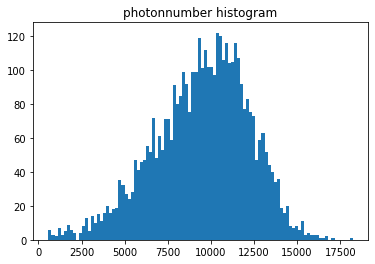

In [12]:
plt.hist(photonsum,bins=100);
plt.title('photonnumber histogram');

In [13]:
photoncount_ok=np.logical_and(photonsum>np.percentile(photonsum,10),photonsum<np.percentile(photonsum,90))
run=run[photoncount_ok]
detector=getattr(run,detectorname)
print(f'photonnumber thresholding done, {len(run)} images remaining')

photonnumber thresholding done, 3378 images remaining


In [14]:
allmean=0
for n,img in enumerate(detector): 
    allmean+=util.photons_simple(img,energy,detector.absolute_gain * 3.65)
    if n%100==0: print(n,end=' ')
allmean/=n+1

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 

/home/gorkhover/zimmf/idi/idi/util.py:14: RuntimeWarning: invalid value encountered in less_equal
  low=blured<=_np.nanpercentile(blured,lowthres)
/home/gorkhover/zimmf/idi/idi/util.py:15: RuntimeWarning: invalid value encountered in greater_equal
  high=blured>=_np.nanpercentile(blured,highthres)


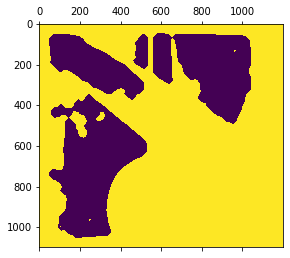

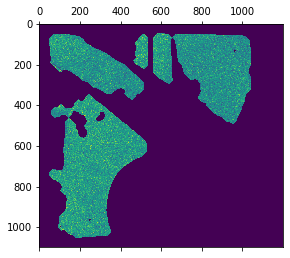

In [15]:
mask=util.create_mask(allmean)
plt.matshow(mask)
plt.matshow(allmean*~mask)

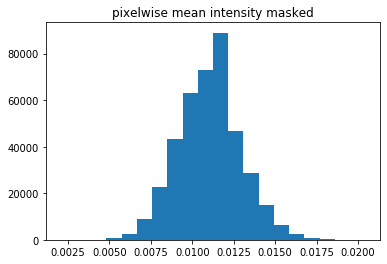

In [16]:
plt.hist(allmean[~mask],bins=20)
plt.title('pixelwise mean intensity masked');

In [17]:
photonsum_masked=[]
allmean_masked=0
for n,img in enumerate(detector): 
    photons=util.photons_simple(img,energy,detector.absolute_gain * 3.65)
    photonsum_masked.append(np.sum(photons))
    allmean_masked+=photons
    if n%100==0: print(n,end=' ')
allmean_masked/=n+1

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 

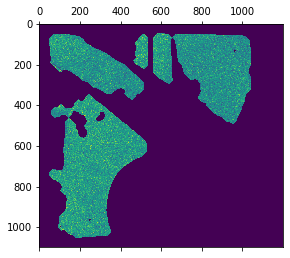

In [18]:
plt.matshow(allmean_masked*~mask)

In [19]:
res=0
weights=0
for n,img in enumerate(detector):
    photons=util.photons_simple(img,energy,detector.absolute_gain * 3.65)
    normalized=photons/allmean_masked
    normalized-=np.mean(normalized[~mask])
    weights+=np.var(normalized[~mask])
    normalized[mask]=0
    res+=recon.simple.corr(normalized)
    if n%100==0:
        print(n,end=' ',flush=True)
    #if n>500:break
res/=weights
norm=recon.simple.corr(~mask) #count of pixelpairs resulting in same q
res=res/norm

0 

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


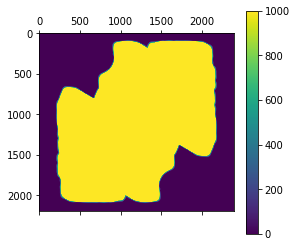

In [20]:
plt.matshow(norm,vmax=1e3)
plt.colorbar()

In [21]:
res[norm<1e3]=np.nan

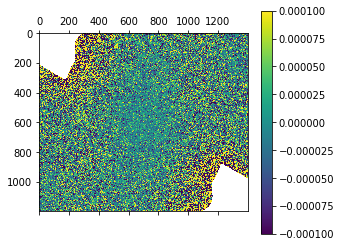

In [22]:
plt.matshow(res[500:-500,500:-500],vmax=0.0001,vmin=-0.0001)
plt.colorbar()

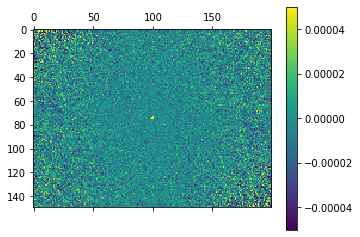

In [23]:
binned=util.bin(res,np.array(res.shape)//4,'mean')
plt.matshow(binned[200:-200,200:-200],vmax=0.00005,vmin=-0.00005)
plt.colorbar()

/home/gorkhover/zimmf/idi/idi/util.py:53: RuntimeWarning: invalid value encountered in true_divide
  radialprofile = databin / nr


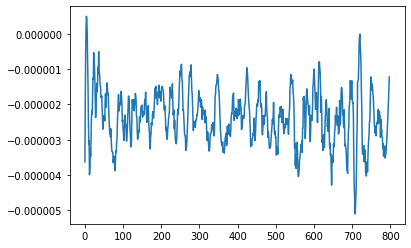

In [24]:
import scipy.signal as ss
rad=util.radial_profile(res,np.array(res.shape)//2)
plt.plot(ss.savgol_filter(rad[2:800],21,3))